In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_json('real_experiences_m_ch.jsonl', lines=True)

In [3]:
df.head()

,episode_index,shift_start,shift_end,order_timestamp,routes,route_update,revenue
0,1,2020-01-20T08:00:00,2020-01-20T20:00:00,2020-01-20T15:59:55,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,0.75
1,1,2020-01-20T08:00:00,2020-01-20T20:00:00,2020-01-20T16:53:07,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,1.75
2,1,2020-01-20T08:00:00,2020-01-20T20:00:00,2020-01-20T16:56:55,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,2.75
3,1,2020-01-20T08:00:00,2020-01-20T20:00:00,2020-01-20T16:58:08,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,3.75
4,1,2020-01-20T08:00:00,2020-01-20T20:00:00,2020-01-20T16:58:14,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,4.25


# Time point


Time point is current point in time since the start of the shift in seconds.

**My interpretation** order timestamp - shift starts (in seconds)

In [4]:
df[['shift_start', 'shift_end','order_timestamp']] = df[['shift_start','shift_end', 'order_timestamp']].apply(pd.to_datetime, infer_datetime_format=True)

In [5]:
df['current_point_in_time'] = (df['order_timestamp'] - df['shift_start']).dt.total_seconds()

In [6]:
df['time_limit_of_the_shift'] = (df['shift_end'] - df['order_timestamp']).dt.total_seconds()

In [7]:
df.head()

,episode_index,shift_start,shift_end,order_timestamp,routes,route_update,revenue,current_point_in_time,time_limit_of_the_shift
0,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 15:59:55,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,0.75,28795.0,14405.0
1,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:53:07,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,1.75,31987.0,11213.0
2,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:56:55,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,2.75,32215.0,10985.0
3,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:58:08,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,3.75,32288.0,10912.0
4,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:58:14,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,4.25,32294.0,10906.0


# Time budget

Extract estimated arrival to depot

Conditions:
1. len(unloaded_drops) != 0
2. last visit is to depot

In [8]:
time = pd.to_datetime(df.route_update.values[0]['unloaded_drops'][-1]['estimated_arrival'])
time_series = pd.Series(time)

In [9]:
def extract_arrival_time_to_depot(route_update, shift_end):
    if len(route_update['unloaded_drops']) == 0:
        raise ValueError(f"unloaded drops cannot be empty")
    
    last_drop = route_update['unloaded_drops'][-1]['drop_type']
    if last_drop != "DEPOT_VISIT":
        raise ValueError(f"last unloaded drop should be depot visit")

    estimated_arrival = pd.to_datetime(route_update['unloaded_drops'][-1]['estimated_arrival'], infer_datetime_format=True)
    
    return (shift_end - estimated_arrival).total_seconds()

In [10]:
df['time_budget'] = df.apply(lambda x: extract_arrival_time_to_depot(x['route_update'], x['shift_end']), axis=1)

In [11]:
df.head()

,episode_index,shift_start,shift_end,order_timestamp,routes,route_update,revenue,current_point_in_time,time_limit_of_the_shift,time_budget
0,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 15:59:55,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,0.75,28795.0,14405.0,12884.0
1,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:53:07,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,1.75,31987.0,11213.0,10643.0
2,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:56:55,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,2.75,32215.0,10985.0,9311.0
3,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:58:08,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,3.75,32288.0,10912.0,9006.0
4,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:58:14,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,4.25,32294.0,10906.0,8879.0


# Flexibility

In [12]:
def extract_flexibility(route_update, shift_end, order_timestamp):
    customer_drops = []
    for drop in range(len(route_update['unloaded_drops'])):
        if route_update['unloaded_drops'][drop]['drop_type'] == 'CUSTOMER_DROP':
            customer_drops.append(route_update['unloaded_drops'][drop])

    if len(customer_drops) == 0:
        return (shift_end - order_timestamp).total_seconds() # Not sure 

    summed_time = 0
    for customer in customer_drops:
        arrival = pd.to_datetime(customer['estimated_arrival'], infer_datetime_format=True)
        deadline = pd.to_datetime(customer['delivery_window']['end'], infer_datetime_format=True)
        diff = (deadline - arrival).total_seconds()
        summed_time += diff 

    return summed_time / len(customer_drops)

In [13]:
df['flexibility'] = df.apply(lambda x: extract_flexibility(x['route_update'], x['shift_end'], x['order_timestamp']), axis=1)

In [14]:
df.head()

,episode_index,shift_start,shift_end,order_timestamp,routes,route_update,revenue,current_point_in_time,time_limit_of_the_shift,time_budget,flexibility
0,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 15:59:55,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,0.75,28795.0,14405.0,12884.0,6461.000000
1,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:53:07,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,1.75,31987.0,11213.0,10643.0,3331.000000
2,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:56:55,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,2.75,32215.0,10985.0,9311.0,2599.000000
3,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:58:08,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,3.75,32288.0,10912.0,9006.0,2543.000000
4,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:58:14,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,4.25,32294.0,10906.0,8879.0,5979.666667


# Average distance per customer

In [15]:
def average_distance_per_customer(route_update):
    customer_drops = []
    summed_distance = 0
    for drop in range(len(route_update['unloaded_drops'])):
        if route_update['unloaded_drops'][drop]['drop_type'] == 'CUSTOMER_DROP':
            customer_drops.append(route_update['unloaded_drops'][drop])
        
        summed_distance += route_update['unloaded_drops'][drop]['leg_distance']

    n_customers = len(customer_drops)
    if not n_customers:
        return 0
    
    return summed_distance / n_customers

In [16]:
df['avg_distance_per_customer'] = df.apply(lambda x: average_distance_per_customer(x['route_update']), axis=1)

In [17]:
df.head()

,episode_index,shift_start,shift_end,order_timestamp,routes,route_update,revenue,current_point_in_time,time_limit_of_the_shift,time_budget,flexibility,avg_distance_per_customer
0,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 15:59:55,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,0.75,28795.0,14405.0,12884.0,6461.000000,14643.000000
1,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:53:07,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,1.75,31987.0,11213.0,10643.0,3331.000000,4852.000000
2,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:56:55,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,2.75,32215.0,10985.0,9311.0,2599.000000,12543.000000
3,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:58:08,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,3.75,32288.0,10912.0,9006.0,2543.000000,7061.500000
4,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:58:14,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,4.25,32294.0,10906.0,8879.0,5979.666667,4787.666667


# Time budget in worst case

In [18]:
def time_budget_in_worst_case(route_update, shift_end):
    time = []
    for drop in range(len(route_update['unloaded_drops'])):
        arrival = pd.to_datetime(route_update['unloaded_drops'][drop]['estimated_arrival'], infer_datetime_format=True)
        time.append(arrival)

    mean = np.mean(pd.Series(time))
    std = np.std(pd.Series(time))
    return (shift_end - (mean + 2 * std)).total_seconds()

In [19]:
df['time_budget_in_worst_case'] = df.apply(lambda x: time_budget_in_worst_case(x['route_update'], x['shift_end']), axis=1)

In [20]:
df.head()

,episode_index,shift_start,shift_end,order_timestamp,routes,route_update,revenue,current_point_in_time,time_limit_of_the_shift,time_budget,flexibility,avg_distance_per_customer,time_budget_in_worst_case
0,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 15:59:55,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,0.75,28795.0,14405.0,12884.0,6461.000000,14643.000000,12409.609949
1,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:53:07,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,1.75,31987.0,11213.0,10643.0,3331.000000,4852.000000,10467.685874
2,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:56:55,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,2.75,32215.0,10985.0,9311.0,2599.000000,12543.000000,8891.739863
3,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:58:08,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,3.75,32288.0,10912.0,9006.0,2543.000000,7061.500000,8660.216213
4,1,2020-01-20 08:00:00,2020-01-20 20:00:00,2020-01-20 16:58:14,[{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a...,{'vehicle_id': 'f520b0fa-ac0a-458b-9c44-e3d8a3...,4.25,32294.0,10906.0,8879.0,5979.666667,4787.666667,8520.249366


# Baseline

In [21]:
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [22]:
train = df.loc[df.episode_index < 19]
train = train[['revenue', 'time_budget', 'flexibility', 'avg_distance_per_customer', 'time_budget_in_worst_case']]
test = df.loc[df.episode_index >= 19]
test = test[['revenue', 'time_budget', 'flexibility', 'avg_distance_per_customer', 'time_budget_in_worst_case']]

In [23]:
X = train.copy()
y = X.pop('revenue')

In [24]:
y_real = test.pop('revenue')

In [25]:
reg = LinearRegression(random_state=1).fit(X, y)

In [26]:
y_pred = reg.predict(test)

In [27]:
mean_squared_error(y_real, y_pred)

66.76250821896251

In [28]:
reg.coef_

array([-0.00512   , -0.00014475, -0.00072706,  0.0030442 ])

In [29]:
reg.intercept_

30.783832051664433

In [30]:
import matplotlib.pyplot as plt

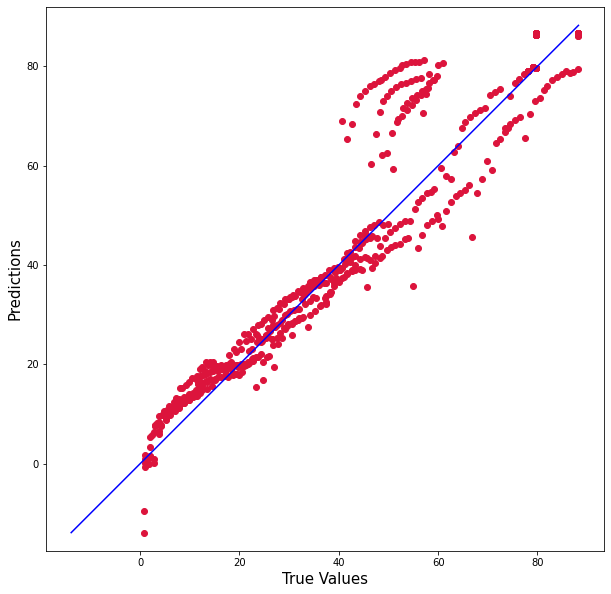

In [31]:
plt.figure(figsize=(10,10))
plt.scatter(y_real, y_pred, c='crimson')

p1 = max(max(y_pred), max(y_real))
p2 = min(min(y_pred), min(y_real))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()